Dataset Shape: (6200, 9)

Target Distribution:
Target
1    3102
0    3098
Name: count, dtype: int64

First 5 rows:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0  -0.471860   0.662549  -3.200412   4.303326  -6.154374  -3.276988   
1   1.275010   1.485601   0.090284   0.278268  -5.691518  -1.004268   
2   2.463563  -1.569119  -1.508619  -2.694873   3.642823   3.449179   
3   3.047362   2.164506   0.346519  -0.677750  -4.493987   2.077430   
4   0.719432   1.990559  -1.312999   0.834297  -5.792556  -1.457983   

   Feature_7  Feature_8  Target  
0  -0.641281   3.869761       1  
1   2.917493  -4.287866       1  
2   0.180411   0.684630       0  
3   2.413197  -5.016015       1  
4   1.740757  -2.300876       1  

Training samples: 4960
Testing samples: 1240

Training models...

 Bagging
Accuracy: 0.9629
AUC Score: 0.9860
OOB Score: 0.9698

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96  

C:\Users\user\AppData\Local\Temp\ipykernel_3740\793785157.py:152: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', ax=axes[1,1], palette='viridis')


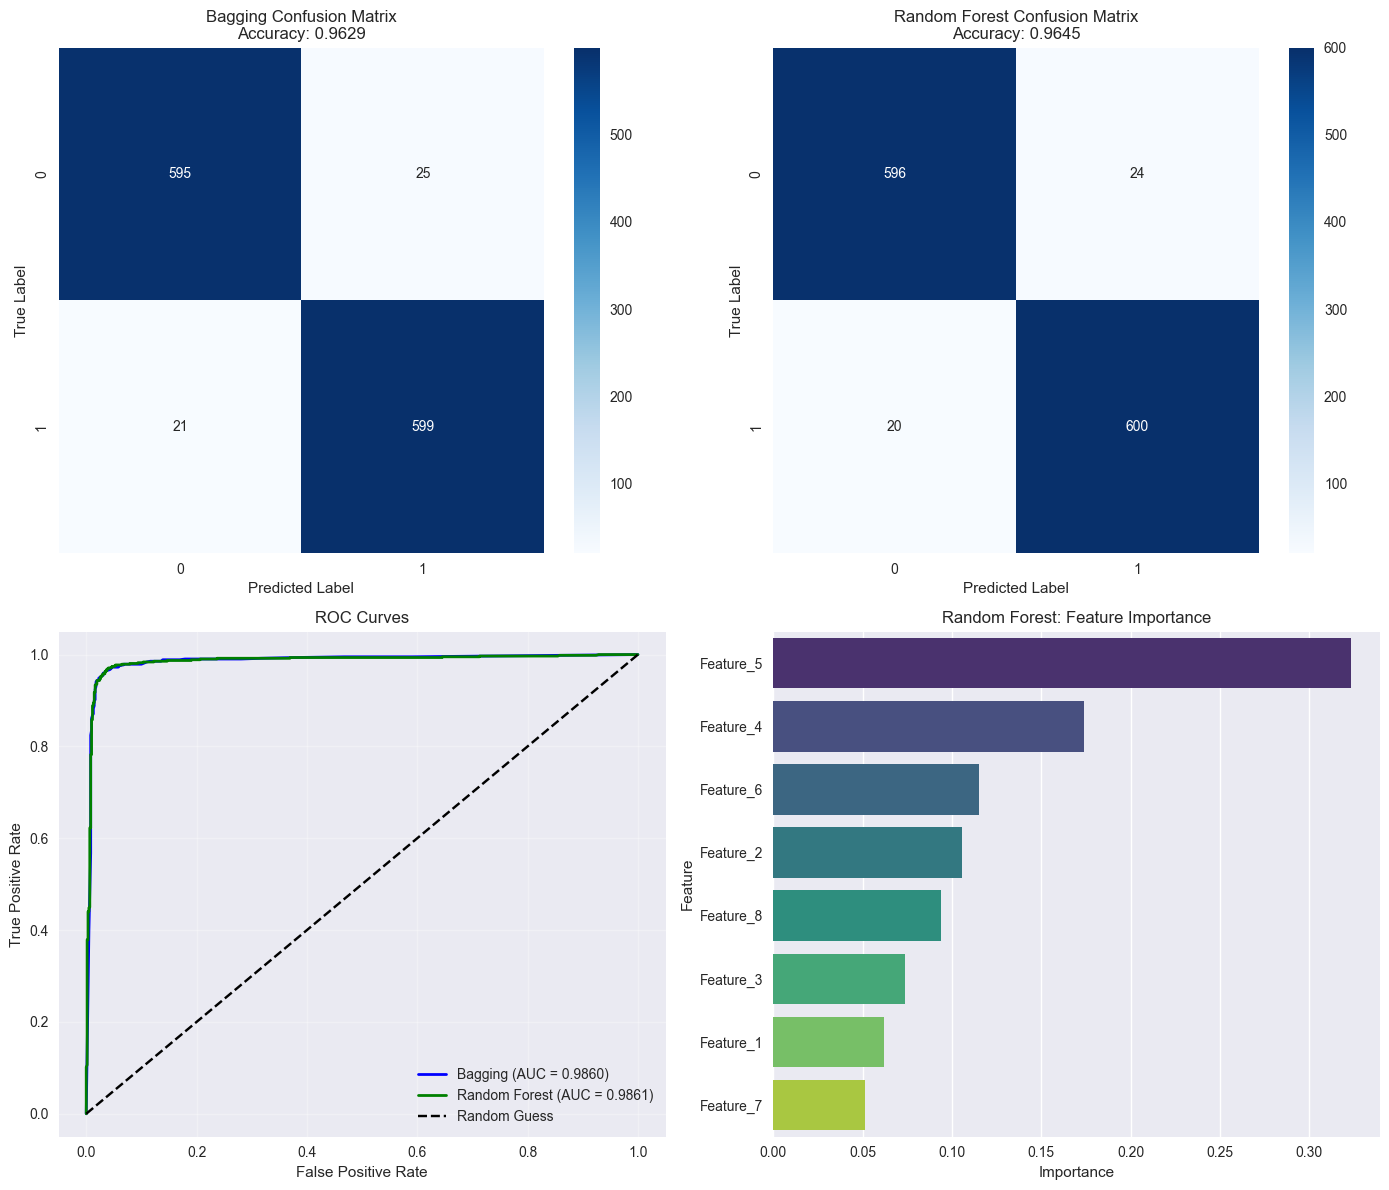


Summary Table:
           Model  Accuracy  AUC Score  OOB Score
0        Bagging    0.9629     0.9860     0.9698
1  Random Forest    0.9645     0.9861     0.9685


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             roc_curve, auc, classification_report)
from sklearn.datasets import make_classification
# Set style for plots
plt.style.use('seaborn-v0_8')

# ---------------------------------------------
# 1. Generate Dataset (6200 rows, 8 features)
# ---------------------------------------------
X, y = make_classification(
    n_samples=6200, n_features=8, n_informative=6,n_redundant=2,
    n_clusters_per_class=1,n_classes=2,class_sep=1.0,
    flip_y=0.01,  # Add slight noise     
    random_state=42
)

# Create feature names
feature_names = [f'Feature_{i+1}' for i in range(8)]
df = pd.DataFrame(X, columns=feature_names)
df['Target'] = y

print("Dataset Shape:", df.shape)
print("\nTarget Distribution:")
print(df['Target'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

# ---------------------------------------------
# 2. Train-Test Split
# ---------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# ---------------------------------------------
# 3. Initialize and Train Models
# ---------------------------------------------
# Base estimator for bagging
base_tree = DecisionTreeClassifier(random_state=42)

# Bagging Classifier
bagging_model = BaggingClassifier(
    estimator=base_tree,
    n_estimators=100,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    bootstrap_features=False,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Train models
print("\nTraining models...")
bagging_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_bagging = bagging_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Prediction probabilities for ROC/AUC
y_prob_bagging = bagging_model.predict_proba(X_test)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# ---------------------------------------------
# 4. Model Evaluation
# ---------------------------------------------
def evaluate_model(y_true, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    auc_score = auc(*roc_curve(y_true, y_prob)[:2])
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    if model_name == "Bagging":
        print(f"OOB Score: {bagging_model.oob_score_:.4f}")
    elif model_name == "Random Forest":
        print(f"OOB Score: {rf_model.oob_score_:.4f}")
    
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred))
    
    return cm, auc_score

# Evaluate both models
cm_bagging, auc_bagging = evaluate_model(y_test, y_pred_bagging, y_prob_bagging, "Bagging")
cm_rf, auc_rf = evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")

# ---------------------------------------------
# 5. Visualization
# ---------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix - Bagging
sns.heatmap(cm_bagging, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title(f'Bagging Confusion Matrix\nAccuracy: {accuracy_score(y_test, y_pred_bagging):.4f}')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# Confusion Matrix - Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title(f'Random Forest Confusion Matrix\nAccuracy: {accuracy_score(y_test, y_pred_rf):.4f}')
axes[0,1].set_ylabel('True Label')
axes[0,1].set_xlabel('Predicted Label')

# ROC Curves
fpr_bag, tpr_bag, _ = roc_curve(y_test, y_prob_bagging)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

axes[1,0].plot(fpr_bag, tpr_bag, label=f'Bagging (AUC = {auc_bagging:.4f})', color='blue', linewidth=2)
axes[1,0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', color='green', linewidth=2)
axes[1,0].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curves')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Feature Importance (Random Forest)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(data=importance_df, x='Importance', y='Feature', ax=axes[1,1], palette='viridis')
axes[1,1].set_title('Random Forest: Feature Importance')

plt.tight_layout()
plt.show()

# ---------------------------------------------
# 6. Summary Table
# ---------------------------------------------
summary = pd.DataFrame({
    'Model': ['Bagging', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_bagging),
        accuracy_score(y_test, y_pred_rf)
    ],
    'AUC Score': [auc_bagging, auc_rf],
    'OOB Score': [bagging_model.oob_score_, rf_model.oob_score_]
})

print("\nSummary Table:")
print(summary.round(4))

Dataset Shape: (6200, 9)

Target Distribution:
Target
1    3102
0    3098
Name: count, dtype: int64

First 5 rows:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0  -0.471860   0.662549  -3.200412   4.303326  -6.154374  -3.276988   
1   1.275010   1.485601   0.090284   0.278268  -5.691518  -1.004268   
2   2.463563  -1.569119  -1.508619  -2.694873   3.642823   3.449179   
3   3.047362   2.164506   0.346519  -0.677750  -4.493987   2.077430   
4   0.719432   1.990559  -1.312999   0.834297  -5.792556  -1.457983   

   Feature_7  Feature_8  Target  
0  -0.641281   3.869761       1  
1   2.917493  -4.287866       1  
2   0.180411   0.684630       0  
3   2.413197  -5.016015       1  
4   1.740757  -2.300876       1  

Training samples: 4960
Testing samples: 1240

Training AdaBoost model...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



 AdaBoost Performance
Accuracy: 0.9355
AUC Score: 0.9791
Number of Weak Learners: 100

 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       620
           1       0.94      0.93      0.93       620

    accuracy                           0.94      1240
   macro avg       0.94      0.94      0.94      1240
weighted avg       0.94      0.94      0.94      1240



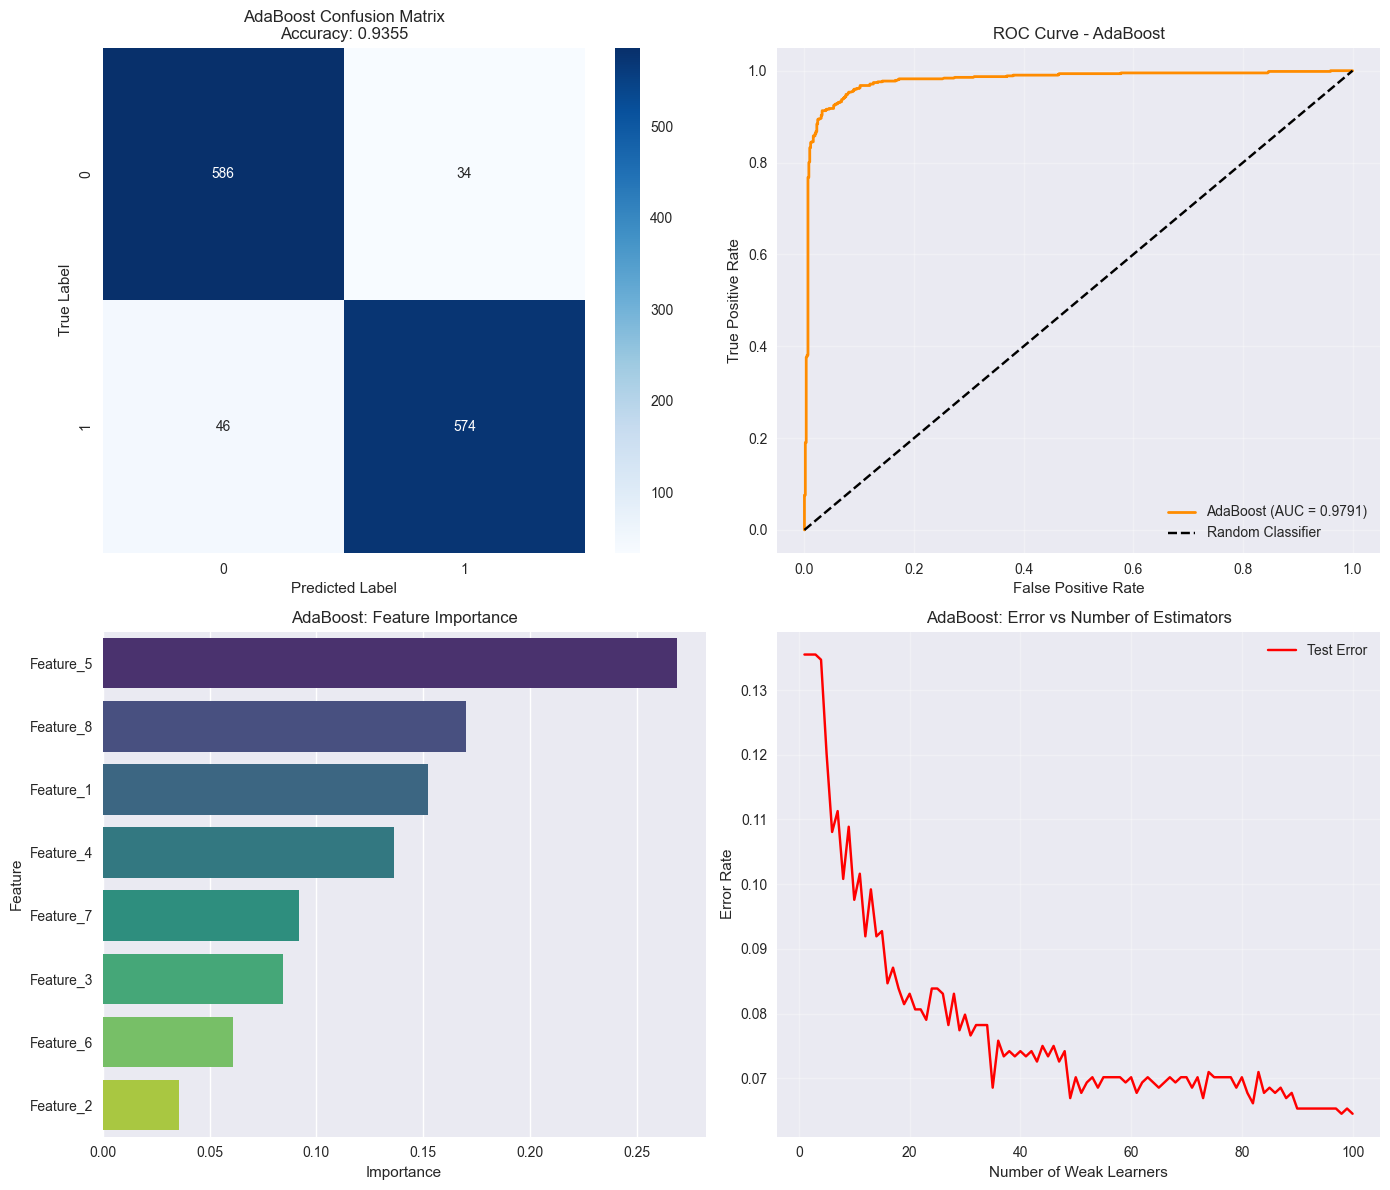


 Model Comparison:
Model           Accuracy   AUC       
-----------------------------------
AdaBoost        0.9355     0.9791    
Random Forest   0.9653     0.9860    
Bagging         0.9702     0.9860    


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             roc_curve, auc, classification_report
)
from sklearn.datasets import make_classification
plt.style.use('seaborn-v0_8')


# ---------------------------------------------
# 1. Generate Dataset (6200 rows, 8 features)
# ---------------------------------------------
X, y = make_classification(
    n_samples=6200, n_features=8, n_informative=6,n_redundant=2,
    n_clusters_per_class=1,n_classes=2,class_sep=1.0,
    flip_y=0.01,  # Add slight noise     
    random_state=42
)

# Create feature names
feature_names = [f'Feature_{i+1}' for i in range(8)]
df = pd.DataFrame(X, columns=feature_names)
df['Target'] = y

print("Dataset Shape:", df.shape)
print("\nTarget Distribution:")
print(df['Target'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

# ---------------------------------------------
# 2. Train-Test Split
# ---------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# ---------------------------------------------
# 3. AdaBoost Model with Decision Stump
# ---------------------------------------------
# Base estimator: Decision stump (shallow tree)
base_classifier = DecisionTreeClassifier(max_depth=1, random_state=42)

# AdaBoost Classifier
ada_model = AdaBoostClassifier(
    estimator=base_classifier,
    n_estimators=100,
    learning_rate=1.0,
    algorithm='SAMME',  
    # Changed from 'SAMME.R' to 'SAMME' for compatibility
    random_state=42
)

# Train the model
print("\nTraining AdaBoost model...")
ada_model.fit(X_train, y_train)

# Predictions
y_pred = ada_model.predict(X_test)
y_pred_proba = ada_model.predict_proba(X_test)[:, 1]  # Probability for positive class

# ---------------------------------------------
# 4. Model Evaluation
# ---------------------------------------------
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)

print(f"\n AdaBoost Performance")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"Number of Weak Learners: {ada_model.n_estimators}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ---------------------------------------------
# 5. Visualization
# ---------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'AdaBoost Confusion Matrix\nAccuracy: {accuracy:.4f}')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# ROC Curve
axes[0, 1].plot(fpr, tpr, label=f'AdaBoost (AUC = {auc_score:.4f})', color='darkorange', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve - AdaBoost')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Feature Importance (Note: Aggregated from weak learners, may not be precise)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': ada_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(data=importance_df, x='Importance', y='Feature', ax=axes[1, 0], hue='Feature', palette='viridis', legend=False)
axes[1, 0].set_title('AdaBoost: Feature Importance')

# Learning Curve: Error vs Number of Estimators (Using staged_predict)
errors = []
for y_pred_stage in ada_model.staged_predict(X_test):
    errors.append(1 - accuracy_score(y_test, y_pred_stage))

axes[1, 1].plot(range(1, len(errors) + 1), errors, label='Test Error', color='red')
axes[1, 1].set_xlabel('Number of Weak Learners')
axes[1, 1].set_ylabel('Error Rate')
axes[1, 1].set_title('AdaBoost: Error vs Number of Estimators')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------------------------------------------
# 6. Compare with Other Models
# ---------------------------------------------
# Train other models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
bagging_model = BaggingClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)
bagging_model.fit(X_train, y_train)

# Model comparison
print("\n Model Comparison:")
print(f"{'Model':<15} {'Accuracy':<10} {'AUC':<10}")
print("-" * 35)

def calc_auc(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return auc(fpr, tpr)

# AdaBoost
acc_ada = accuracy_score(y_test, y_pred)
auc_ada = calc_auc(y_test, y_pred_proba)
print(f"{'AdaBoost':<15} {acc_ada:<10.4f} {auc_ada:<10.4f}")

# Random Forest
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = calc_auc(y_test, y_prob_rf)
print(f"{'Random Forest':<15} {acc_rf:<10.4f} {auc_rf:<10.4f}")

# Bagging
y_pred_bag = bagging_model.predict(X_test)
y_prob_bag = bagging_model.predict_proba(X_test)[:, 1]
acc_bag = accuracy_score(y_test, y_pred_bag)
auc_bag = calc_auc(y_test, y_prob_bag)
print(f"{'Bagging':<15} {acc_bag:<10.4f} {auc_bag:<10.4f}")

Dataset Shape: (6200, 9)

Target Distribution:
Target
1    3102
0    3098
Name: count, dtype: int64

First 5 rows:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0  -0.471860   0.662549  -3.200412   4.303326  -6.154374  -3.276988   
1   1.275010   1.485601   0.090284   0.278268  -5.691518  -1.004268   
2   2.463563  -1.569119  -1.508619  -2.694873   3.642823   3.449179   
3   3.047362   2.164506   0.346519  -0.677750  -4.493987   2.077430   
4   0.719432   1.990559  -1.312999   0.834297  -5.792556  -1.457983   

   Feature_7  Feature_8  Target  
0  -0.641281   3.869761       1  
1   2.917493  -4.287866       1  
2   0.180411   0.684630       0  
3   2.413197  -5.016015       1  
4   1.740757  -2.300876       1  

Training samples: 4960
Testing samples: 1240

Training AdaBoost model...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



 AdaBoost Performance
Accuracy: 0.9355
AUC Score: 0.9791
Number of Weak Learners: 100

 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       620
           1       0.94      0.93      0.93       620

    accuracy                           0.94      1240
   macro avg       0.94      0.94      0.94      1240
weighted avg       0.94      0.94      0.94      1240



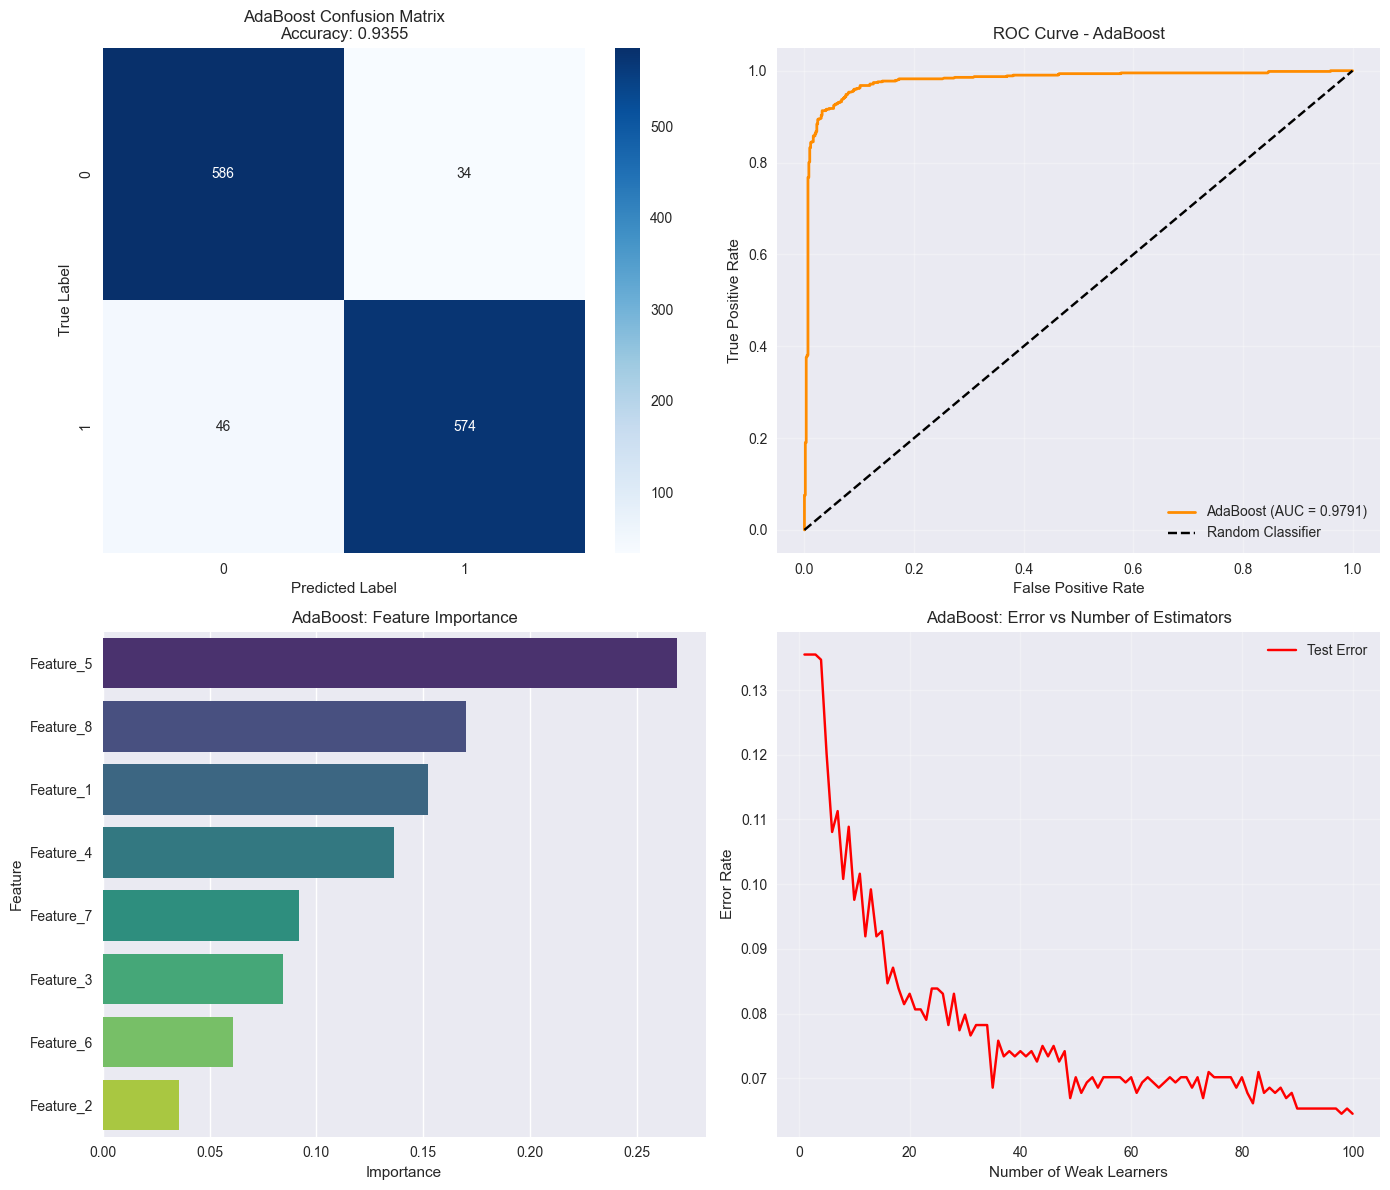


Training additional models...

 Model Comparison:
Model                     Accuracy   AUC       
---------------------------------------------
AdaBoost                  0.9355     0.9791    
Random Forest             0.9653     0.9860    
Bagging                   0.9702     0.9860    
Gradient Boosting         0.9637     0.9841    
XGBoost                   0.9653     0.9847    
LightGBM                  0.9677     0.9856    


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier,
                            BaggingClassifier, GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             roc_curve, auc, classification_report
)
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
plt.style.use('seaborn-v0_8')


# ---------------------------------------------
# 1. Generate Dataset (6200 rows, 8 features)
# ---------------------------------------------
X, y = make_classification(
    n_samples=6200, n_features=8, n_informative=6,n_redundant=2,
    n_clusters_per_class=1,n_classes=2,class_sep=1.0,
    flip_y=0.01,  # Add slight noise     
    random_state=42
)

# Create feature names
feature_names = [f'Feature_{i+1}' for i in range(8)]
df = pd.DataFrame(X, columns=feature_names)
df['Target'] = y

print("Dataset Shape:", df.shape)
print("\nTarget Distribution:")
print(df['Target'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

# ---------------------------------------------
# 2. Train-Test Split
# ---------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# ---------------------------------------------
# 3. AdaBoost Model with Decision Stump
# ---------------------------------------------
# Base estimator: Decision stump (shallow tree)
base_classifier = DecisionTreeClassifier(max_depth=1, random_state=42)

# AdaBoost Classifier
ada_model = AdaBoostClassifier(
    estimator=base_classifier,
    n_estimators=100,
    learning_rate=1.0,
    algorithm='SAMME',  # Compatible with older scikit-learn versions
    random_state=42
)

# Train the model
print("\nTraining AdaBoost model...")
ada_model.fit(X_train, y_train)

# Predictions
y_pred = ada_model.predict(X_test)
y_pred_proba = ada_model.predict_proba(X_test)[:, 1]  # Probability for positive class

# ---------------------------------------------
# 4. Model Evaluation
# ---------------------------------------------
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)

print(f"\n AdaBoost Performance")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"Number of Weak Learners: {ada_model.n_estimators}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ---------------------------------------------
# 5. Visualization
# ---------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'AdaBoost Confusion Matrix\nAccuracy: {accuracy:.4f}')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# ROC Curve
axes[0, 1].plot(fpr, tpr, label=f'AdaBoost (AUC = {auc_score:.4f})', color='darkorange', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve - AdaBoost')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Feature Importance (Note: Aggregated from weak learners, may not be precise)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': ada_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(data=importance_df, x='Importance', y='Feature', ax=axes[1, 0], hue='Feature', palette='viridis', legend=False)
axes[1, 0].set_title('AdaBoost: Feature Importance')

# Learning Curve: Error vs Number of Estimators (Using staged_predict)
errors = []
for y_pred_stage in ada_model.staged_predict(X_test):
    errors.append(1 - accuracy_score(y_test, y_pred_stage))

axes[1, 1].plot(range(1, len(errors) + 1), errors, label='Test Error', color='red')
axes[1, 1].set_xlabel('Number of Weak Learners')
axes[1, 1].set_ylabel('Error Rate')
axes[1, 1].set_title('AdaBoost: Error vs Number of Estimators')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------------------------------------------
# 6. Compare with Other Models
# ---------------------------------------------
# Train other models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
bagging_model = BaggingClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
lgb_model = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

# Fit all models
print("\nTraining additional models...")
rf_model.fit(X_train, y_train)
bagging_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Model comparison
print("\n Model Comparison:")
print(f"{'Model':<25} {'Accuracy':<10} {'AUC':<10}")
print("-" * 45)

def calc_auc(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return auc(fpr, tpr)

# AdaBoost
acc_ada = accuracy_score(y_test, y_pred)
auc_ada = calc_auc(y_test, y_pred_proba)
print(f"{'AdaBoost':<25} {acc_ada:<10.4f} {auc_ada:<10.4f}")

# Random Forest
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = calc_auc(y_test, y_prob_rf)
print(f"{'Random Forest':<25} {acc_rf:<10.4f} {auc_rf:<10.4f}")

# Bagging
y_pred_bag = bagging_model.predict(X_test)
y_prob_bag = bagging_model.predict_proba(X_test)[:, 1]
acc_bag = accuracy_score(y_test, y_pred_bag)
auc_bag = calc_auc(y_test, y_prob_bag)
print(f"{'Bagging':<25} {acc_bag:<10.4f} {auc_bag:<10.4f}")

# Gradient Boosting
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]
acc_gb = accuracy_score(y_test, y_pred_gb)
auc_gb = calc_auc(y_test, y_prob_gb)
print(f"{'Gradient Boosting':<25} {acc_gb:<10.4f} {auc_gb:<10.4f}")

# XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = calc_auc(y_test, y_prob_xgb)
print(f"{'XGBoost':<25} {acc_xgb:<10.4f} {auc_xgb:<10.4f}")

# LightGBM
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]
acc_lgb = accuracy_score(y_test, y_pred_lgb)
auc_lgb = calc_auc(y_test, y_prob_lgb)
print(f"{'LightGBM':<25} {acc_lgb:<10.4f} {auc_lgb:<10.4f}")

Dataset Shape: (6200, 9)

Target Distribution:
Target
1    3102
0    3098
Name: count, dtype: int64

First 5 rows:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0  -0.471860   0.662549  -3.200412   4.303326  -6.154374  -3.276988   
1   1.275010   1.485601   0.090284   0.278268  -5.691518  -1.004268   
2   2.463563  -1.569119  -1.508619  -2.694873   3.642823   3.449179   
3   3.047362   2.164506   0.346519  -0.677750  -4.493987   2.077430   
4   0.719432   1.990559  -1.312999   0.834297  -5.792556  -1.457983   

   Feature_7  Feature_8  Target  
0  -0.641281   3.869761       1  
1   2.917493  -4.287866       1  
2   0.180411   0.684630       0  
3   2.413197  -5.016015       1  
4   1.740757  -2.300876       1  

Training samples: 4960
Testing samples: 1240

Training AdaBoost model...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



 AdaBoost Performance
Accuracy: 0.9355
AUC Score: 0.9791
Number of Weak Learners: 100

 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       620
           1       0.94      0.93      0.93       620

    accuracy                           0.94      1240
   macro avg       0.94      0.94      0.94      1240
weighted avg       0.94      0.94      0.94      1240



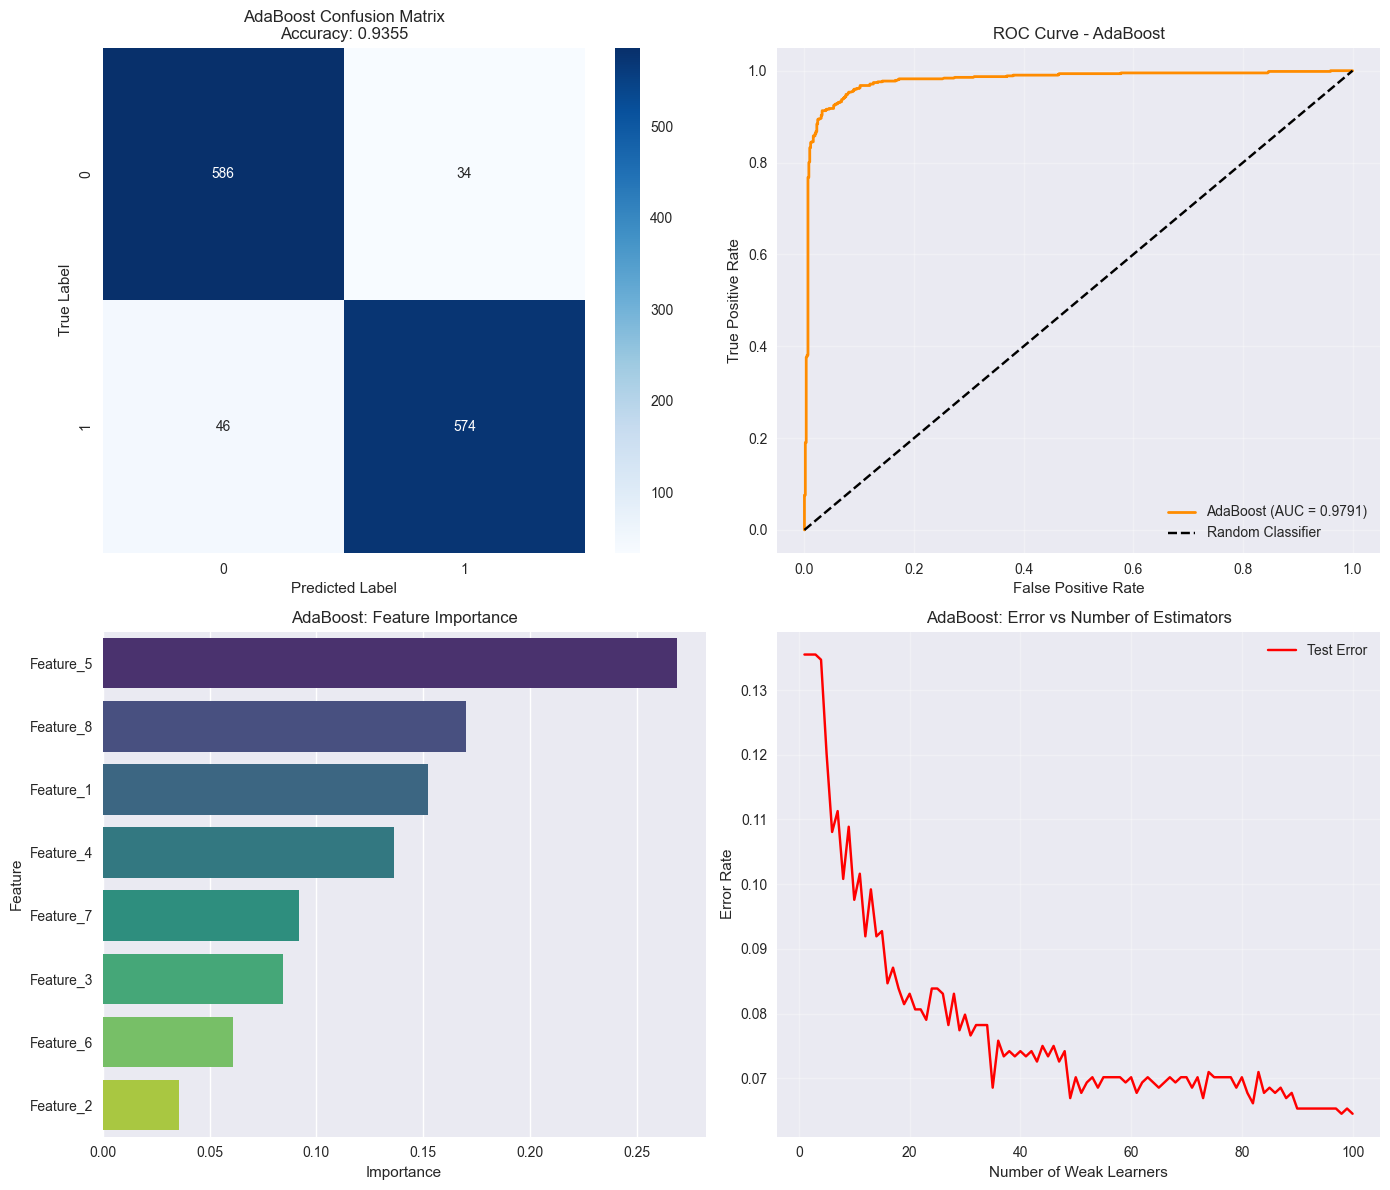


Training additional models...
Training Stacking Ensemble...

 Model Comparison:
Model                     Accuracy   AUC       
---------------------------------------------
AdaBoost                  0.9355     0.9791    
Random Forest             0.9653     0.9860    
Bagging                   0.9702     0.9860    
Gradient Boosting         0.9637     0.9841    
XGBoost                   0.9653     0.9847    
LightGBM                  0.9677     0.9856    
Stacking Ensemble         0.9694     0.9861    


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier,
                            BaggingClassifier,GradientBoostingClassifier,
                              StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             roc_curve, auc, classification_report
)
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
plt.style.use('seaborn-v0_8')


# ---------------------------------------------
# 1. Generate Dataset (6200 rows, 8 features)
# ---------------------------------------------
X, y = make_classification(
    n_samples=6200, n_features=8, n_informative=6,n_redundant=2,
    n_clusters_per_class=1,n_classes=2,class_sep=1.0,
    flip_y=0.01,  # Add slight noise     
    random_state=42
)

# Create feature names
feature_names = [f'Feature_{i+1}' for i in range(8)]
df = pd.DataFrame(X, columns=feature_names)
df['Target'] = y

print("Dataset Shape:", df.shape)
print("\nTarget Distribution:")
print(df['Target'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

# ---------------------------------------------
# 2. Train-Test Split
# ---------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# ---------------------------------------------
# 3. AdaBoost Model with Decision Stump
# ---------------------------------------------
# Base estimator: Decision stump (shallow tree)
base_classifier = DecisionTreeClassifier(max_depth=1, random_state=42)

# AdaBoost Classifier
ada_model = AdaBoostClassifier(
    estimator=base_classifier,
    n_estimators=100,
    learning_rate=1.0,
    algorithm='SAMME',  # Compatible with older scikit-learn versions
    random_state=42
)

# Train the model
print("\nTraining AdaBoost model...")
ada_model.fit(X_train, y_train)

# Predictions
y_pred = ada_model.predict(X_test)
y_pred_proba = ada_model.predict_proba(X_test)[:, 1]  # Probability for positive class

# ---------------------------------------------
# 4. Model Evaluation
# ---------------------------------------------
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)

print(f"\n AdaBoost Performance")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"Number of Weak Learners: {ada_model.n_estimators}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ---------------------------------------------
# 5. Visualization
# ---------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'AdaBoost Confusion Matrix\nAccuracy: {accuracy:.4f}')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# ROC Curve
axes[0, 1].plot(fpr, tpr, label=f'AdaBoost (AUC = {auc_score:.4f})', color='darkorange', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve - AdaBoost')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Feature Importance (Note: Aggregated from weak learners, may not be precise)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': ada_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(data=importance_df, x='Importance', y='Feature', ax=axes[1, 0], hue='Feature', palette='viridis', legend=False)
axes[1, 0].set_title('AdaBoost: Feature Importance')

# Learning Curve: Error vs Number of Estimators (Using staged_predict)
errors = []
for y_pred_stage in ada_model.staged_predict(X_test):
    errors.append(1 - accuracy_score(y_test, y_pred_stage))

axes[1, 1].plot(range(1, len(errors) + 1), errors, label='Test Error', color='red')
axes[1, 1].set_xlabel('Number of Weak Learners')
axes[1, 1].set_ylabel('Error Rate')
axes[1, 1].set_title('AdaBoost: Error vs Number of Estimators')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------------------------------------------
# 6. Compare with Other Models
# ---------------------------------------------
# Define base models for stacking and individual evaluation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
bagging_model = BaggingClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
lgb_model = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

# Stacking Ensemble
estimators = [
    ('ada', ada_model),
    ('rf', rf_model),
    ('bag', bagging_model),
    ('gb', gb_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
]
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),
    cv=5,
    n_jobs=-1  # Use all available CPU cores
)

# Train all models
print("\nTraining additional models...")
rf_model.fit(X_train, y_train)
bagging_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
print("Training Stacking Ensemble...")
stacking_model.fit(X_train, y_train)

# Model comparison
print("\n Model Comparison:")
print(f"{'Model':<25} {'Accuracy':<10} {'AUC':<10}")
print("-" * 45)

def calc_auc(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return auc(fpr, tpr)

# AdaBoost
acc_ada = accuracy_score(y_test, y_pred)
auc_ada = calc_auc(y_test, y_pred_proba)
print(f"{'AdaBoost':<25} {acc_ada:<10.4f} {auc_ada:<10.4f}")

# Random Forest
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = calc_auc(y_test, y_prob_rf)
print(f"{'Random Forest':<25} {acc_rf:<10.4f} {auc_rf:<10.4f}")

# Bagging
y_pred_bag = bagging_model.predict(X_test)
y_prob_bag = bagging_model.predict_proba(X_test)[:, 1]
acc_bag = accuracy_score(y_test, y_pred_bag)
auc_bag = calc_auc(y_test, y_prob_bag)
print(f"{'Bagging':<25} {acc_bag:<10.4f} {auc_bag:<10.4f}")

# Gradient Boosting
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]
acc_gb = accuracy_score(y_test, y_pred_gb)
auc_gb = calc_auc(y_test, y_prob_gb)
print(f"{'Gradient Boosting':<25} {acc_gb:<10.4f} {auc_gb:<10.4f}")

# XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = calc_auc(y_test, y_prob_xgb)
print(f"{'XGBoost':<25} {acc_xgb:<10.4f} {auc_xgb:<10.4f}")

# LightGBM
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]
acc_lgb = accuracy_score(y_test, y_pred_lgb)
auc_lgb = calc_auc(y_test, y_prob_lgb)
print(f"{'LightGBM':<25} {acc_lgb:<10.4f} {auc_lgb:<10.4f}")

# Stacking Ensemble
y_pred_stack = stacking_model.predict(X_test)
y_prob_stack = stacking_model.predict_proba(X_test)[:, 1]
acc_stack = accuracy_score(y_test, y_pred_stack)
auc_stack = calc_auc(y_test, y_prob_stack)
print(f"{'Stacking Ensemble':<25} {acc_stack:<10.4f} {auc_stack:<10.4f}")